In [1]:
input_form = """
<table>
<td style="border-style: none;">
<div style="border: solid 2px #666; width: 143px; height: 144px;">
<canvas width="140" height="140"></canvas>
</div></td>
<td style="border-style: none;">
<button onclick="clear_value()">Clear</button>
</td>
</table>
"""


javascript = """
<script type="text/Javascript">
    var pixels = [];
    for (var i = 0; i < 28*28; i++) pixels[i] = 0
    var click = 0;


    var canvas = document.querySelector("canvas");
    canvas.addEventListener("mousemove", function(e){
        if (e.buttons == 1) {
            click = 1;
            canvas.getContext("2d").fillStyle = "rgb(0,0,0)";
            canvas.getContext("2d").fillRect(e.offsetX, e.offsetY, 8, 8);
            x = Math.floor(e.offsetY * 0.2)
            y = Math.floor(e.offsetX * 0.2) + 1
            for (var dy = 0; dy < 2; dy++){
                for (var dx = 0; dx < 2; dx++){
                    if ((x + dx < 28) && (y + dy < 28)){
                        pixels[(y+dy)+(x+dx)*28] = 1
                    }
                }
            }
        } else {
            if (click == 1) set_value()
            click = 0;
        }
    });
    
    function set_value(){
        var result = ""
        for (var i = 0; i < 28*28; i++) result += pixels[i] + ","
        var kernel = IPython.notebook.kernel;
        kernel.execute("image = [" + result + "]");
    }
    
    function clear_value(){
        canvas.getContext("2d").fillStyle = "rgb(255,255,255)";
        canvas.getContext("2d").fillRect(0, 0, 140, 140);
        for (var i = 0; i < 28*28; i++) pixels[i] = 0
    }
</script>
"""

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data


#이미 그래프가 있을 경우 중복이 될 수 있기 때문에, 기존 그래프를 모두 리셋한다.
tf.reset_default_graph() 


num_filters1 = 32


x = tf.placeholder(tf.float32, [None, 784])
x_image = tf.reshape(x, [-1,28,28,1])


#  layer 1
W_conv1 = tf.Variable(tf.truncated_normal([5,5,1,num_filters1],
                                          stddev=0.1))
h_conv1 = tf.nn.conv2d(x_image, W_conv1,
                       strides=[1,1,1,1], padding='SAME')


b_conv1 = tf.Variable(tf.constant(0.1, shape=[num_filters1]))
h_conv1_cutoff = tf.nn.relu(h_conv1 + b_conv1)


h_pool1 =tf.nn.max_pool(h_conv1_cutoff, ksize=[1,2,2,1],
                        strides=[1,2,2,1], padding='SAME')


num_filters2 = 64


# layer 2
W_conv2 = tf.Variable(
            tf.truncated_normal([5,5,num_filters1,num_filters2],
                                stddev=0.1))
h_conv2 = tf.nn.conv2d(h_pool1, W_conv2,
                       strides=[1,1,1,1], padding='SAME')


b_conv2 = tf.Variable(tf.constant(0.1, shape=[num_filters2]))
h_conv2_cutoff = tf.nn.relu(h_conv2 + b_conv2)


h_pool2 =tf.nn.max_pool(h_conv2_cutoff, ksize=[1,2,2,1],
                        strides=[1,2,2,1], padding='SAME')


# fully connected layer
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*num_filters2])


num_units1 = 7*7*num_filters2
num_units2 = 1024


w2 = tf.Variable(tf.truncated_normal([num_units1, num_units2]))
b2 = tf.Variable(tf.constant(0.1, shape=[num_units2]))
hidden2 = tf.nn.relu(tf.matmul(h_pool2_flat, w2) + b2)


keep_prob = tf.placeholder(tf.float32)
hidden2_drop = tf.nn.dropout(hidden2, keep_prob)


w0 = tf.Variable(tf.zeros([num_units2, 10]))
b0 = tf.Variable(tf.zeros([10]))
k = tf.matmul(hidden2_drop, w0) + b0
p = tf.nn.softmax(k)


# prepare session
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
saver.restore(sess, './test_session/cnn_session')


print('reload has been done')

INFO:tensorflow:Restoring parameters from ./test_session/cnn_session
reload has been done


In [3]:
from IPython.display import HTML
HTML(input_form + javascript)

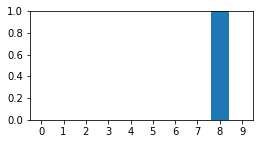

In [4]:
p_val = sess.run(p, feed_dict={x:[image], keep_prob:1.0})


fig = plt.figure(figsize=(4,2))
pred = p_val[0]
subplot = fig.add_subplot(1,1,1)
subplot.set_xticks(range(10))
subplot.set_xlim(-0.5,9.5)
subplot.set_ylim(0,1)
subplot.bar(range(10), pred, align='center')
plt.show()

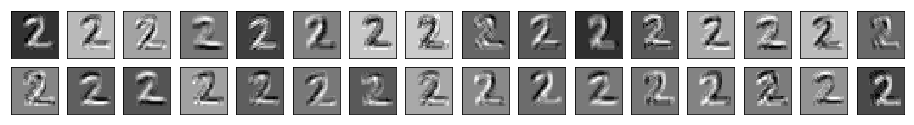

In [7]:
conv1_vals, cutoff1_vals = sess.run(
    [h_conv1, h_conv1_cutoff], feed_dict={x:[image], keep_prob:1.0})


fig = plt.figure(figsize=(16,4))


for f in range(num_filters1):
    subplot = fig.add_subplot(4, 16, f+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(conv1_vals[0,:,:,f],
                   cmap=plt.cm.gray_r, interpolation='nearest') 
plt.show()

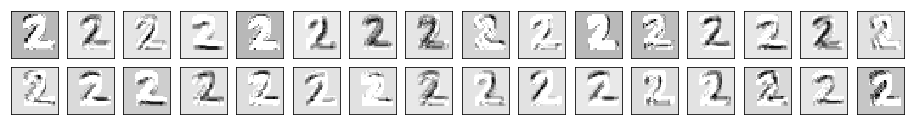

In [8]:
fig = plt.figure(figsize=(16,4))


for f in range(num_filters1):
    subplot = fig.add_subplot(4, 16, f+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(cutoff1_vals[0,:,:,f],
                   cmap=plt.cm.gray_r, interpolation='nearest') 
    
plt.show()